# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).\
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.\
- Бюджет на разработку скважин в регионе — 10 млрд рублей.\
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.\
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.\
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_list = [df0, df1, df2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Количество уникальных идентификаторов скважин: 99990
Количество дубликатов: 0


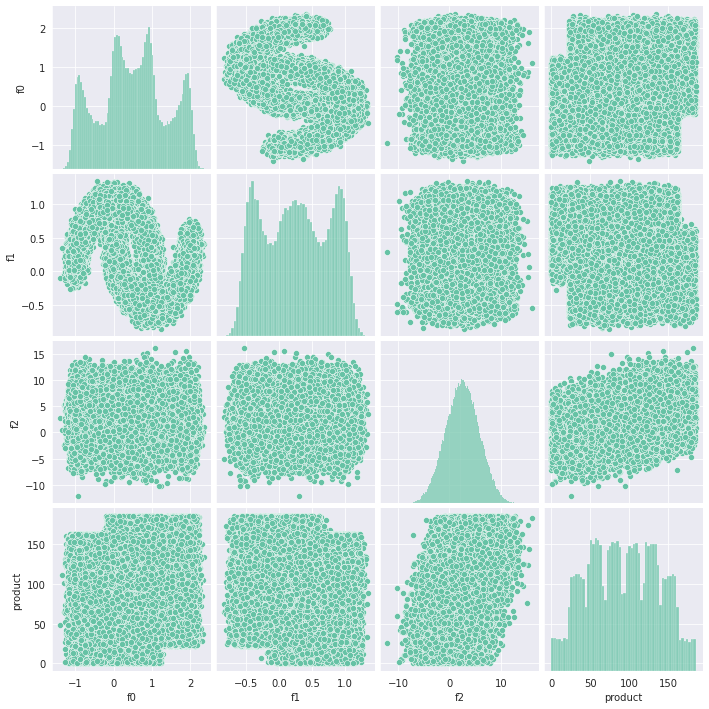

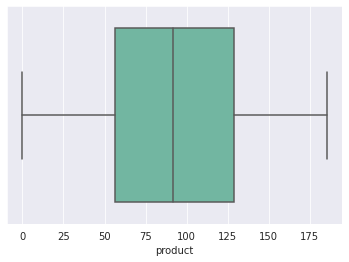

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Количество уникальных идентификаторов скважин: 99996
Количество дубликатов: 0


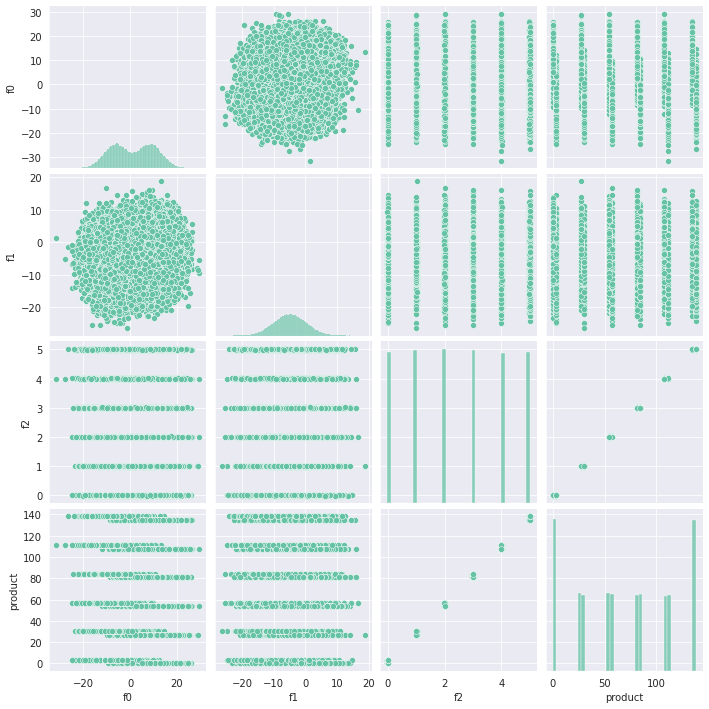

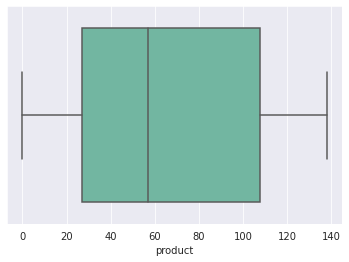

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Количество уникальных идентификаторов скважин: 99996
Количество дубликатов: 0


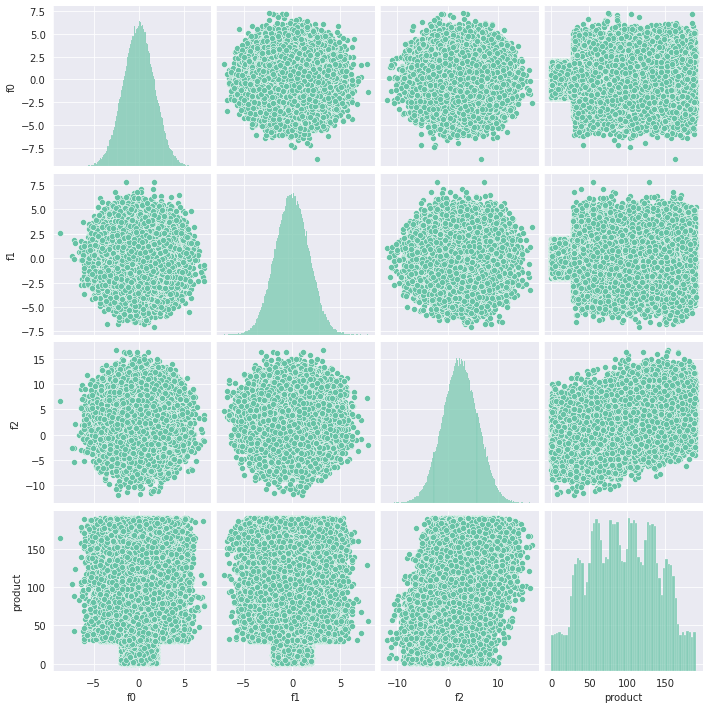

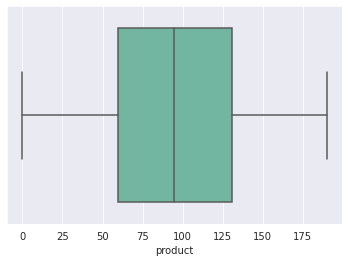

In [4]:
for df in df_list:
    df.info()
    display(df.head())
    display(df.describe())
    print('Количество уникальных идентификаторов скважин:', df['id'].nunique())
    print('Количество дубликатов:', df0.loc[df0.duplicated()]['id'].count())
    sns.set_style('darkgrid')
    sns.set_palette('Set2')
    sns.pairplot(df)
    plt.show()
    sns.boxplot(x=df['product'])
    plt.show()

**Вывод**

В целом в имеющихся данных по регионам отсутствуют аномальные значения и выбросы по значениям признаков. По матрице диаграмм видно отсутствие мультиколлинеарности в данных. Однако, во втором регионе можно увидеть сильную корреляцию между признаком f2 и  показателем product.

При рассмотрении уникальных значений столбцов id во всех трёх регионах были обнаружены повторяющиеся, при этом не являющиеся явными дубликатами. В виду малого количества таких значений (10 для первого региона и 4 - для второго и третьего) данные можно оставить.

**Оценка объёма запасов**

Для первого региона:
- разброс значений составляет от 0 до 185 тыс. баррелей
- половина значений находится в диапазоне от 56 до 128 тыс. баррелей

Для второго региона:
- разброс значений составляет от 0 до 138 тыс. баррелей
- половина значений находится в диапазоне от 27 до 107 тыс. баррелей

Для третьего региона:
- разброс значений составляет от 0 до 190 тыс. баррелей
- половина значений находится в диапазоне от 59 до 130 тыс. баррелей

## Обучение и проверка модели

### Разбивка данных на обучающую и валидационную выборки в соотношении 75:25

### Обучение модели и получение предсказаний на валидационной выборке

Выбираем в качестве модели линейную регрессию и напишем функцию, принимающую на вход датафрейм и выдающую выборки и разобъём данные по регионам на выборки.

In [5]:
model = LinearRegression()

In [6]:
def get_predictions(df):
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    return predictions, target_valid

### Сохранение предсказаний и правильных ответов на валидационной выборке

In [7]:
predictions_0, target_0 = get_predictions(df0)
predictions_1, target_1 = get_predictions(df1)
predictions_2, target_2 = get_predictions(df2)

In [8]:
# проверка
display(predictions_0.shape)
target_0.shape

(25000,)

(25000,)

### Вывод на экран среднего запаса предсказанного сырья и RMSE модели

In [9]:
def predictions_mean_model_RMSE(predictions, target):
    predictions_mean = predictions.mean()
    RMSE = mean_squared_error(target, predictions)**0.5
    return predictions_mean, RMSE

In [10]:
predictions_mean_0, RMSE_0 = predictions_mean_model_RMSE(predictions_0, target_0)
predictions_mean_1, RMSE_1 = predictions_mean_model_RMSE(predictions_1, target_1)
predictions_mean_2, RMSE_2 = predictions_mean_model_RMSE(predictions_2, target_2)
print('Средний запас предсказанного сырья:', predictions_mean_0.round(2), 'RMSE модели:', RMSE_0.round(2))
print('Средний запас предсказанного сырья:', predictions_mean_1.round(2), 'RMSE модели:', RMSE_1.round(2))
print('Средний запас предсказанного сырья:', predictions_mean_2.round(2), 'RMSE модели:', RMSE_2.round(2))

Средний запас предсказанного сырья: 92.59 RMSE модели: 37.58
Средний запас предсказанного сырья: 68.73 RMSE модели: 0.89
Средний запас предсказанного сырья: 94.97 RMSE модели: 40.03


### Анализ результатов

В среднем первый и третий регионы имеют больший объем запасов нефти, однако при этом имеют и высокую ошибку прогнозирования запасов. Второй регион характеризуется несколько меньшим объемом запасов, однако точность прогнозирования очень высока.Вероятно, это обусловлено ранее выявленной корреляцией между признаком f2 и product.

## Подготовка к расчёту прибыли

### Сохранение всех ключевых для расчетов значений в отдельных переменных

In [11]:
units = 500 # количество точек для разведки в регионе
top_units = 200 # количество лучших точек для разработки
budget = 10000000000 # бюджет на разработку скважин в регионе
profit_per_unit = 450000 # доход с продукта - 450000 рублей за 1000 баррелей

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [12]:
breakeven_point = int(budget/(profit_per_unit*top_units))
print(f'Достаточный объём сырья для безубыточной разработки скважины составляет {breakeven_point} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки скважины составляет 111 тыс. баррелей


### Выводы по этапу подготовки расчёта прибыли

Получили безубыточный объем сырья 111 тыс. баррелей. Согласно полученным ранее данным, это значение превосходит средние имеющиеся запасы по скважинам во всех регионах. Тем не менее во всех регионах есть объекты, запасы которых превосходят безубыточный объем.

## Функция для расчета прибыли по выбранным скважинам и предсказаниям модели

### Выбор скважин с максимальными значениями предсказаний

### Суммирование целевых значение объёма сырья, соответствующего этим предсказаниям

In [13]:
def revenue(target, predictions):
    revenue = 0
    sorted_predictions = predictions.sort_values(ascending=False).head(top_units)
    selected_units = target[sorted_predictions.index][:top_units]
    for unit in selected_units:
        revenue += (unit - breakeven_point) * profit_per_unit
    return revenue

### Рассчет прибыли для полученного объёма сырья

In [14]:
region_0 = revenue(target_0, predictions_0)
region_1 = revenue(target_1, predictions_1)
region_2 = revenue(target_2, predictions_2)

In [15]:
print(f'Прибыль в регионе region_0: {int(region_0/1000000)} млн. руб.')
print(f'Прибыль в регионе region_1: {int(region_1/1000000)} млн. руб.')
print(f'Прибыль в регионе region_2: {int(region_2/1000000)} млн. руб.')

Прибыль в регионе region_0: 3330 млн. руб.
Прибыль в регионе region_1: 2425 млн. руб.
Прибыль в регионе region_2: 2720 млн. руб.


## Расчет рисков и прибыли для каждого региона

### Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Расчет средней прибыли, 95%-го доверительного интервала и риска убытков. Убыток — это отрицательная прибыль

Функция определяет искомые параметры для 200 лучших скважин из 500 случайных.

In [16]:
def bootstrap(target, predictions):
    state = np.random.RandomState(12345)
    profit = []
    for i in range(1000):
        target_subsample = target.sample(units, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        profit.append(revenue(target_subsample, predictions_subsample))
    profit = pd.Series(profit)
    lower = (profit.quantile(0.025)/1e6).round(2)
    upper = (profit.quantile(0.975)/1e6).round(2)
    risk_loss = (profit < 0).mean()
    print(f'Средняя выручка: {(profit.mean()/1e6).round(2)} млн. руб.')
    print(f'95% доверительный интервал от {lower} до {upper} млн. руб.')
    print(f'Риск убытков: {(risk_loss*100).round(2)}%')

In [17]:
bootstrap_region_0 = bootstrap(target_0, predictions_0)
bootstrap_region_1 = bootstrap(target_1, predictions_1)
bootstrap_region_2 = bootstrap(target_2, predictions_2)

Средняя выручка: 435.94 млн. руб.
95% доверительный интервал от -92.09 до 957.98 млн. руб.
Риск убытков: 5.8%
Средняя выручка: 525.22 млн. руб.
95% доверительный интервал от 78.87 до 941.55 млн. руб.
Риск убытков: 0.8%
Средняя выручка: 445.01 млн. руб.
95% доверительный интервал от -118.88 до 979.71 млн. руб.
Риск убытков: 6.1%


### Выводы: предложение региона для разработки скважин и обоснование выбора

**Первый регион:**\
Средняя выручка: 435.94 млн. руб.\
95% доверительный интервал от -92.09 до 957.98 млн. руб.\
Риск убытков: 5.8%

**Второй регион:**\
Средняя выручка: 525.22 млн. руб.\
95% доверительный интервал от 78.87 до 941.55 млн. руб.\
Риск убытков: 0.8%

**Третий регион:**\
Средняя выручка: 445.01 млн. руб.\
95% доверительный интервал от -118.88 до 979.71 млн. руб.\
Риск убытков: 6.1%

**Вывод:** 
Для разработки сырья наиболее подходящим является второй регион как с точки зрения прогнозируемой средней прибыли (максимальное значение среди трёх регионов), так и с точки зрения риска убытков (минимальный риск среди всех регионов). 